In [1]:
import sys
sys.path.append("../../../")

from utils.misc import select_cuda_device
device = select_cuda_device()

Selected device 3, which has 10820 MB available.


In [2]:
import torch

import matplotlib.pyplot as plt

from einops import rearrange

from hydra import initialize, compose
from hydra.utils import instantiate

from smc.images import ImageModel, M71ImageModel

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose(config_name="config")

---

**Gaussian PSF (default in `ImageModel`):**

In [4]:
image_model = ImageModel(image_height = 25,
                         image_width = 25,
                         background = 491.5867919921875,
                         psf_stdev = 1.9273269405185427)

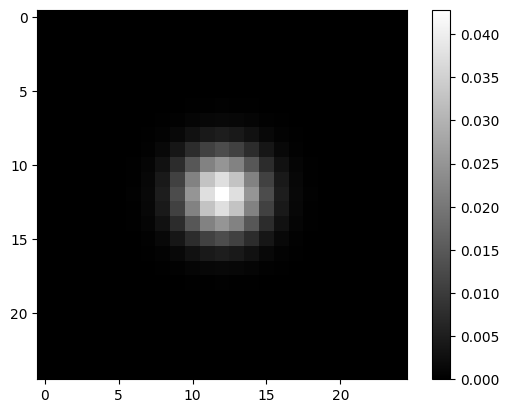

In [5]:
locs = torch.zeros([1,1,1,1,2])
locs[...,0,:] = torch.tensor([12.5, 12.5])

gaussian_psf = image_model.psf(locs).squeeze()

_ = plt.imshow(gaussian_psf, cmap = 'gray')
_ = plt.colorbar()

**SDSS PSF (rasterized):**

In [6]:
sdss = instantiate(cfg.surveys.sdss)
sdss.prepare_data()

In [7]:
sdss_psf = sdss.psf.psf_galsim[sdss.image_id(0)][2].original.image.array

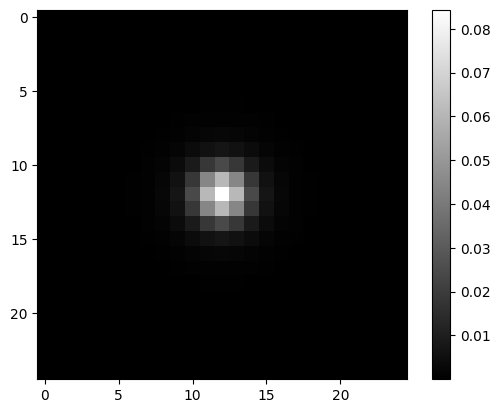

In [8]:
_ = plt.imshow(sdss_psf, cmap = 'gray')
_ = plt.colorbar()

**SDSS PSF (model-based, with a Gaussian core and a power-law wing):**

In [9]:
m71_image_model = M71ImageModel(image_height = sdss_psf.shape[0],
                                image_width = sdss_psf.shape[1],
                                background = sdss[0]['background'][2][900:1220,1728:2048].mean(),
                                flux_calibration = torch.tensor(sdss[0]['flux_calibration'][2][1728:2048]).median(),
                                psf_params = sdss.psf.psf_params[sdss.image_id(0)][2],
                                noise_scale = 2.0)

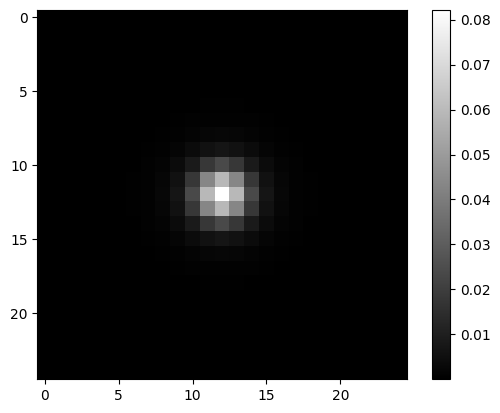

In [10]:
sdss_psf2 = m71_image_model.psf(locs).squeeze()
_ = plt.imshow(sdss_psf2, cmap = 'gray')
_ = plt.colorbar()

**Compare the two SDSS PSFs:**

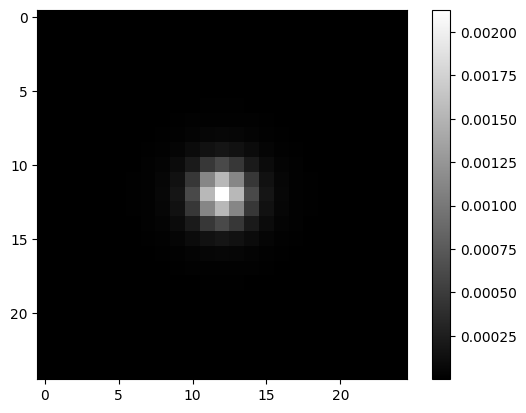

In [11]:
_ = plt.imshow(sdss_psf - sdss_psf2.numpy(), cmap = 'gray')
_ = plt.colorbar()

---

**Compare to empirical PSF from an M71 tile with one isolated source**

In [12]:
tiles = torch.load("data/tiles.pt")
counts = torch.load("data/counts_magcut.pt")
locs = torch.load("data/locs_magcut.pt")
fluxes = torch.load("data/fluxes_magcut.pt")

In [13]:
m71_image_model = M71ImageModel(image_height = tiles.shape[1], # changed from above
                                image_width = tiles.shape[2], # changed from above
                                background = sdss[0]['background'][2][900:1220,1728:2048].mean(),
                                flux_calibration = torch.tensor(sdss[0]['flux_calibration'][2][1728:2048]).median(),
                                psf_params = sdss.psf.psf_params[sdss.image_id(0)][2],
                                noise_scale = 2.0)

Here's an actual tile:

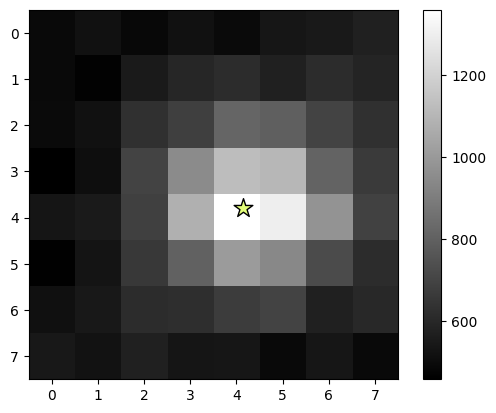

In [14]:
idx = torch.where((counts == 1) * ((locs[...,0,0] - 4).abs() < 1) * ((locs[...,0,1] - 4).abs() < 1))[0][7].item()
_ = plt.imshow(tiles[idx], cmap = 'gray')
_ = plt.colorbar()
_ = plt.scatter(locs[idx][...,:1,1] - 0.5,
                locs[idx][...,:1,0] - 0.5,
                c = fluxes[idx][...,0], marker = '*', cmap = 'Wistia', s = 200, edgecolors = 'black')

Here's a noiseless reconstruction based on our PSF model:

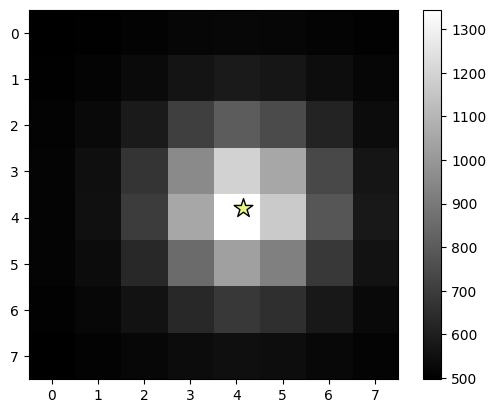

In [15]:
psf = m71_image_model.psf(rearrange(locs[idx], "d t -> 1 1 1 d t"))
rate = (
    psf
    * rearrange(
        m71_image_model.flux_calibration * rearrange(fluxes[idx], "d -> 1 1 1 d"), "numH numW n d -> numH numW 1 1 n d"
    )
).sum(-1) + m71_image_model.background
rate = rate.squeeze()

_ = plt.imshow(rate, cmap = 'gray')
_ = plt.colorbar()
_ = plt.scatter(locs[idx][...,:1,1] - 0.5,
                locs[idx][...,:1,0] - 0.5,
                c = fluxes[idx][...,0], marker = '*', cmap = 'Wistia', s = 200, edgecolors = 'black')

And here's the difference between the actual tile and our noiseless reconstruction:

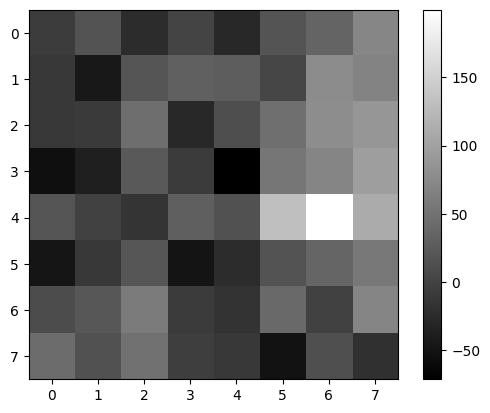

In [16]:
_ = plt.imshow(tiles[idx] - rate, cmap = 'gray')
_ = plt.colorbar()